# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

Date : 04-08-2021

### Loading libs

In [1]:
PATH = '/home/homer/anaconda3/envs/HM/bin/python'
Sys.setenv(RETICULATE_PYTHON = PATH)

current_dir <- getwd()
mogp_dir <- current_dir #mogp_emulator lib : https://github.com/alan-turing-institute/mogp-emulator

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/')) #devel version og ExeterUQ_MOGP : https://github.com/BayesExeter/ExeterUQ_MOGP/tree/devel

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

r_packages <- c("future.apply", 'tgp', 'ANN2', 'MLmetrics', 'keras')
invisible(lapply(r_packages, library, character.only = TRUE))

python_pkg <- c("L96_amip", "numpy", "sklearn", "skopt.sampler", "skopt.space")
python_pkg_names <- c("L96_amip", "np", "sklearn", "sampler", "skSpace")
for(i in seq(length(python_pkg))){assign(python_pkg_names[i], import(python_pkg[i]))}

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘keras’


The following

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
X \\
\bar{Y} \\
X^{2} \\
X \bar{Y}\\
\bar{Y^{2}}
\end{array}\right)
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
X_init = l96_two$X

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))

n_iter <- 40

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0), amip_metrics=FALSE))

   user  system elapsed 
  0.554   0.048   0.602 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
n_samples <- 40

In [10]:
space <- skSpace$Space(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20))) ##only h,F,c,b
lhs <- sampler$Lhs()
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

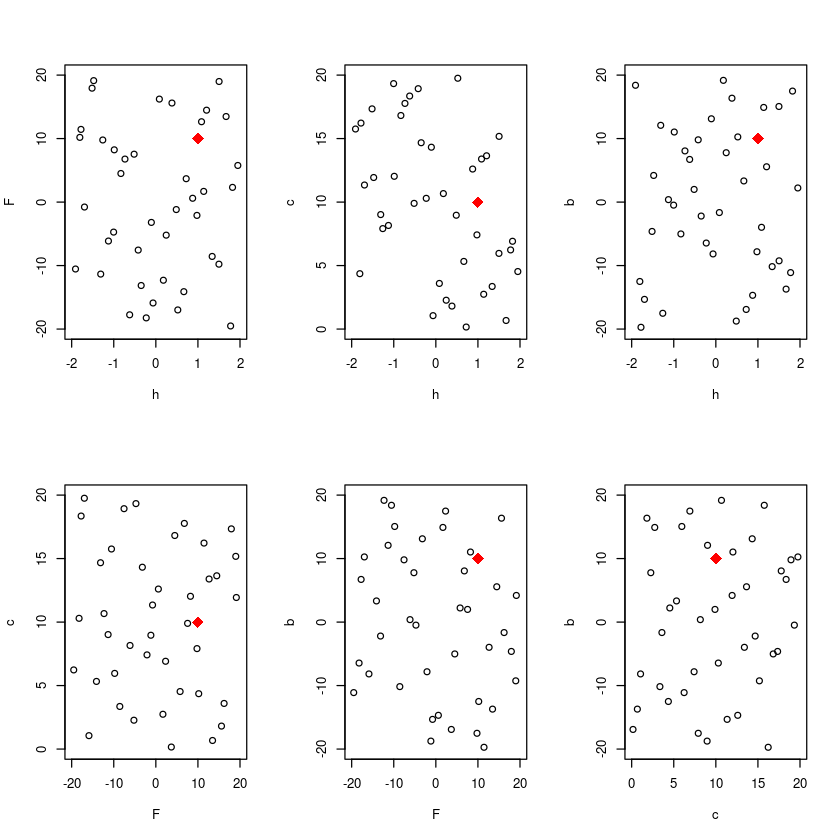

In [11]:
par(mfrow=c(2,3))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,3], inputs_wave1[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [12]:
extract_metrics_AMIP <- function(p, n_iter, dt, initX) {
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=p[[2]], c=p[[3]], b=p[[4]])
    l96_mip$iterate(n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0), amip_metrics=FALSE))
}

In [13]:
plan(multicore, workers = 8, gc = TRUE)

In [14]:
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave1 <- t(metrics_wave1)

## Principal Component Analysis for dimensionality reduction

In [15]:
# Generate data for testing PCA
n_samples_test <- 40
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))
metrics_test = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test <- t(metrics_test)

In [16]:
# Scale metrics
my.scaler <- sklearn$preprocessing$StandardScaler()
X <- my.scaler$fit_transform(metrics_wave1)
X_test <- my.scaler$transform(metrics_test)
input_size = dim(X)[[2]]

In [17]:
latent_size <- 32

#Create encoder
enc_input = layer_input(shape = input_size)
enc_output = enc_input %>% 
  layer_dense(units=latent_size, activation = "tanh") 
encoder = keras_model(enc_input, enc_output)

#Create decoder
dec_input = layer_input(shape = latent_size)
dec_output = dec_input %>% 
  layer_dense(units = input_size, activation = "linear") 
decoder = keras_model(dec_input, dec_output)

#Create autoencoder
aen_input = layer_input(shape = input_size)
aen_output = aen_input %>% 
  encoder() %>% 
  decoder()
   
ae = keras_model(aen_input, aen_output)
summary(ae)

Model: "model_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                [(None, 180)]                   0           
________________________________________________________________________________
model (Functional)                  (None, 32)                      5792        
________________________________________________________________________________
model_1 (Functional)                (None, 180)                     5940        
Total params: 11,732
Trainable params: 11,732
Non-trainable params: 0
________________________________________________________________________________


In [18]:
ae %>% compile(optimizer="Adam", loss="mean_squared_error")
ae %>% fit(X,X, epochs=500, batch_size=8, validation_data =list(X_test, X_test), workers=8, use_multiprocessing=TRUE)

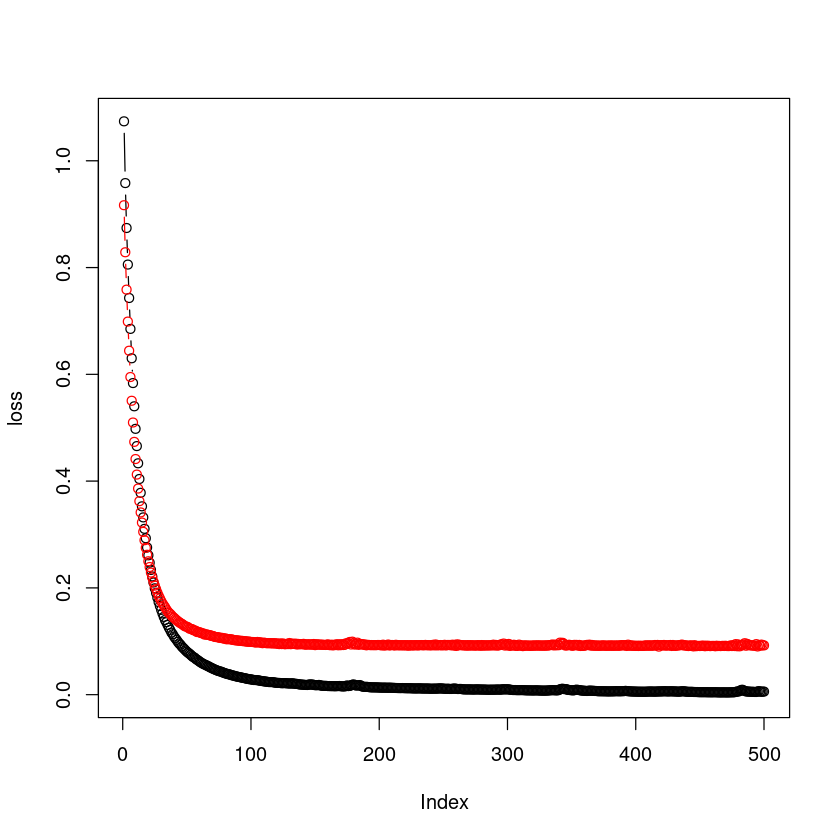

In [19]:
loss <- ae$history$history$loss
val.loss <- ae$history$history$val_loss
max.loss <- max(c(loss, val.loss))
plot(loss, type='b', ylim=c(0, max.loss))
lines(val.loss, col='red', type='b')
legend(600, 1, legend=c("AE mse", "AE val mse"), 
       col=c('black', 'red'),
       lty=1:4,
       title="Losses")


In [20]:
val.loss[length(val.loss)]
loss[length(loss)]

[1] 0.0922864

[1] 0.005776037

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [21]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [22]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave1_scaled <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1_scaled) <- c('h', 'F', 'c', 'b')


X_ae <- encoder %>% predict(X)
N = nrow(X_ae) 
noise <- rnorm(N, 0.5, 0)
tData_ae <- data.frame(cbind(inputs_wave1_scaled, noise, X_ae))
names(tData_ae)[names(tData_ae) == "noise"] <- "Noise"
         
head(tData_ae)

,h,F,c,b,Noise,X1,X2,X3,X4,X5,⋯,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.24272128,-0.0589672,-0.1036056,-0.93729158,0.5,0.5254946,-0.2872964,0.17002025,-0.8464907,-0.4775126,⋯,0.1605080,0.1693638,-0.35663345,-0.15313558,-0.3319040,-0.1230330,-0.5253159,0.66414011,-0.8607365,0.4436691
2,0.74974022,-0.4890278,-0.4040966,0.75287034,0.5,-0.2037486,-0.5973689,-0.80553257,-0.5643063,-0.3469133,⋯,0.2744310,-0.2075531,-0.40964058,-0.72834760,0.1083986,-0.2229503,0.4440293,0.91558802,-0.2476058,-0.2868088
3,-0.63048968,0.4890101,-0.2089569,-0.87576325,0.5,0.2229679,0.4721917,0.83514643,-0.2397197,-0.3790527,⋯,-0.2441590,0.8982533,-0.24578734,0.34364507,0.1224385,-0.6247733,-0.7322980,-0.53138143,-0.2469733,0.9445219
4,-0.88941915,0.5723452,0.6221371,-0.98601571,0.5,0.2701842,0.4701940,0.90526283,-0.4592703,-0.1667174,⋯,-0.0875577,0.8550881,-0.38393801,0.40309298,0.0617263,-0.7112474,-0.6456035,0.05690034,-0.1143030,0.9099934
5,-0.56311389,-0.3067018,-0.1841641,0.01920742,0.5,0.4494023,0.0301659,-0.58528745,-0.1526205,-0.4349397,⋯,0.3434145,-0.8941397,-0.22286637,0.16677342,-0.3175663,-0.2376245,-0.9065023,-0.91048485,0.5397643,-0.7868184
6,-0.05324286,-0.1601800,0.4320671,0.65591650,0.5,0.5027333,-0.2110377,0.01012306,-0.6803997,-0.5355672,⋯,0.1756126,0.0904839,-0.01828157,0.07166002,-0.2721682,-0.2967218,-0.5424049,0.54173005,-0.8929278,0.1290630


### Training emulator

In [23]:
cands <- names(tData_ae)[1:4]
em_wave1 <- BuildNewEmulators(tData_ae, HowManyEmulators = ncol(X_ae), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0750375065349099 using F"
[1] "Max reduction is 0.146686771681125 using F"
[1] "Max reduction is 0.0913224378396584 using h"
[1] "Max reduction is 0.0200412647768079 using Three Way Interactions with F"
[1] "Max reduction is 0.0142613676185362 using b"
[1] "Max reduction is 0.0162393318061527 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ F + I(F^2) + h + b + c + I(h * F) + I(b * F) + 
    I(c * F) + I(b * h) + I(c * h) + I(c * b) + I(F * h * F) + 
    I(F * b * F) + I(F * c * F) + I(F * b * h) + I(F * c * h) + 
    I(F * c * b), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47704 -0.08690  0.00241  0.10223  0.74117 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.575722   0.094994   6.061 4.23e-06 ***
F             0.710642   0.100890   7.044 4.56e-07 ***
I(F^2)       -1.440242   0.210314  -6.848 7.04e-07 ***
h             0.029049   0.179660   0.162   0.8730    
b   

We can use Leave One Out to verify if our GPs fit our metrics correctly.

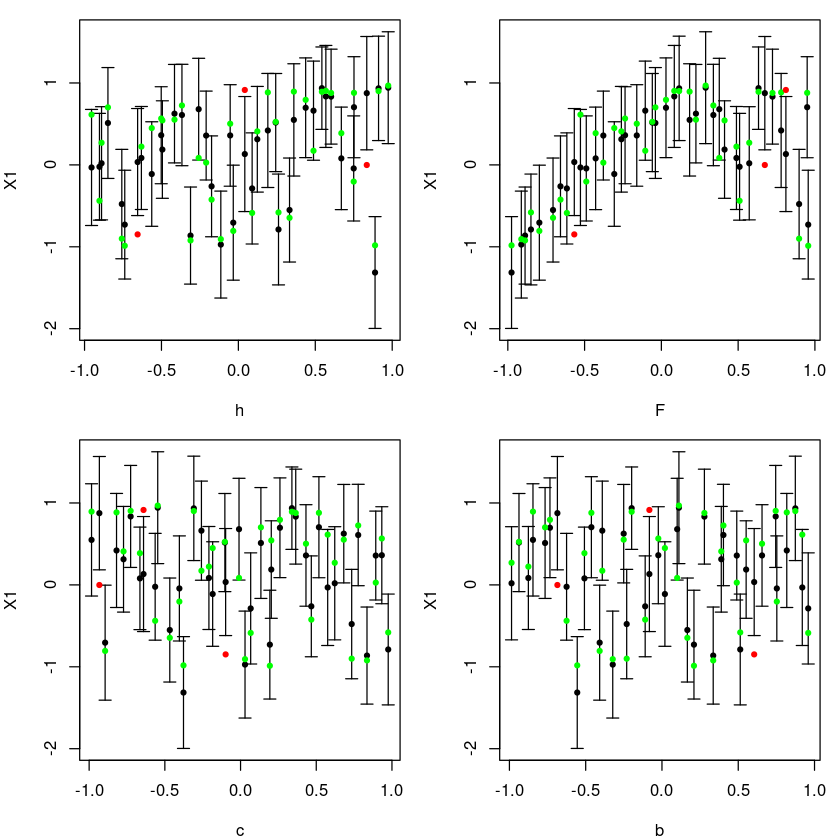

In [24]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 1, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [25]:
tDisc_ae <- rep(0, ncol(X_ae)) # model discrepancy variance Var[g] 
tObsErr_ae <- rep(0, ncol(X_ae)) # observational error variance Var[e]
obs_scaled <- my.scaler$transform(t(observations))
tObs_ae <-  encoder %>% predict(obs_scaled)

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [26]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc_ae, Obs=tObs_ae, ObsErr=tObsErr_ae))

   user  system elapsed 
 33.821   9.950  10.282 

In [27]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),F=c(10),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h   F c   b
1 0.5 0.5 0 0.5


In [28]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.04838

### Layout of NROY space

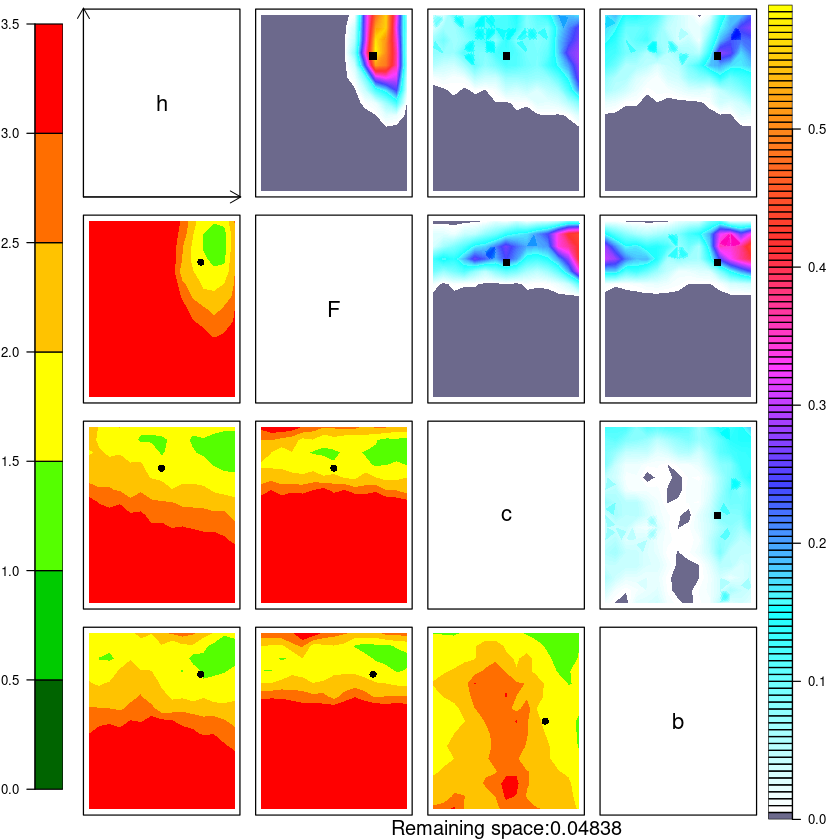

In [29]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [30]:
n <- ceiling(n_samples*4/scoreNROY1)

In [31]:
space <- skSpace$Space(list(c(-1, 1), c(-1,1), c(-1, 1), c(-1, 1))) ## we use a scaled space
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [32]:
parameters_space <- function(emulators, NewData, n_samples=n_samples, Discrepancy, Obs, ObsErr){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc_ae, Obs=tObs_ae, ObsErr=tObsErr_ae)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [33]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 40, tDisc_ae, tObs_ae, tObserr_ae)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [34]:
inputs_wave2_scaled <- inputs_wave2_scaled_temp[NROY_temp_wave2,]
inputs_wave2 <- rangeUnscale(inputs_wave2_scaled, my_bounds, range = c(-1, 1))

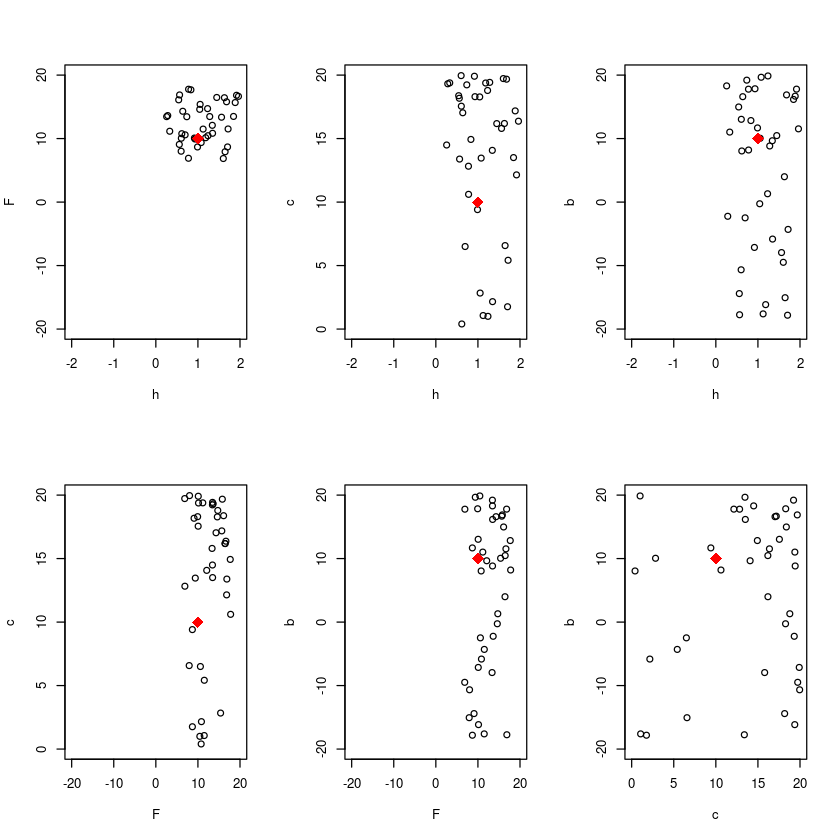

In [35]:
par(mfrow=c(2,3))
plot(inputs_wave2[,1], inputs_wave2[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,3], inputs_wave2[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [36]:
metrics_wave2 = future_sapply(1:nrow(inputs_wave2), function(r) extract_metrics_AMIP(inputs_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave2 <- t(metrics_wave2)

## Autoencoder for dimensionality reduction

In [37]:
inputs_test_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(21)))

In [38]:
NROY_temp_test_wave2 <- parameters_space(emulators, inputs_test_wave2_scaled_temp, 40, tDisc_ae, tObs_ae, tObserr_ae)

In [39]:
inputs_test_wave2_scaled <- inputs_test_wave2_scaled_temp[NROY_temp_test_wave2,]
inputs_test_wave2 <- rangeUnscale(inputs_test_wave2_scaled, my_bounds, range = c(-1, 1))

In [40]:
metrics_test_wave2 = future_sapply(1:nrow(inputs_test_wave2), function(r) extract_metrics_AMIP(inputs_test_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave2 <- t(metrics_test_wave2)

In [41]:
# Scale metrics
my.scaler_wave2 <- sklearn$preprocessing$StandardScaler()
X_wave2 <- my.scaler_wave2$fit_transform(metrics_wave2)
X_test_wave2 <- my.scaler$transform(metrics_test_wave2)

In [42]:
latent_size <- 32

#Create encoder
enc_input = layer_input(shape = input_size)
enc_output = enc_input %>% 
  layer_dense(units=latent_size, activation = "tanh") 
encoder = keras_model(enc_input, enc_output)

#Create decoder
dec_input = layer_input(shape = latent_size)
dec_output = dec_input %>% 
  layer_dense(units = input_size, activation = "linear") #%>%
  #layer_dropout(rate=0.05)
decoder = keras_model(dec_input, dec_output)

#Create autoencoder
aen_input = layer_input(shape = input_size)
aen_output = aen_input %>% 
  encoder() %>% 
  decoder()
   
ae = keras_model(aen_input, aen_output)
summary(ae)

Model: "model_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_6 (InputLayer)                [(None, 180)]                   0           
________________________________________________________________________________
model_3 (Functional)                (None, 32)                      5792        
________________________________________________________________________________
model_4 (Functional)                (None, 180)                     5940        
Total params: 11,732
Trainable params: 11,732
Non-trainable params: 0
________________________________________________________________________________


In [43]:
ae %>% compile(optimizer="Adam", loss="mean_squared_error")
ae %>% fit(X_wave2, X_wave2, epochs=500, batch_size=8, validation_data =list(X_test, X_test), workers=8, use_multiprocessing=TRUE)

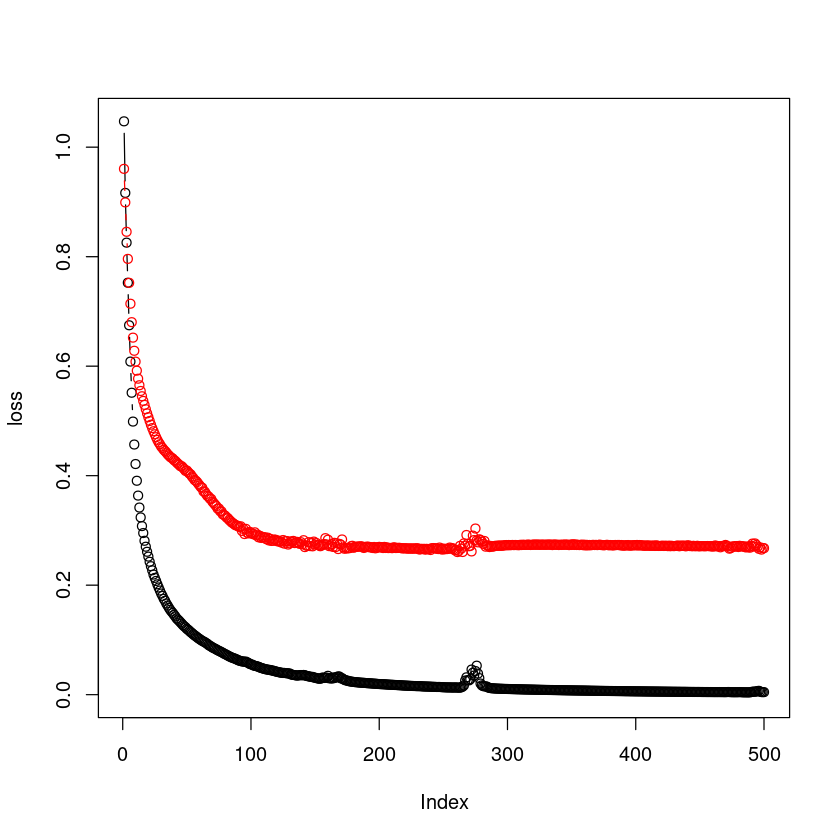

In [44]:
loss <- ae$history$history$loss
val.loss <- ae$history$history$val_loss
max.loss <- max(c(loss, val.loss))
plot(loss, type='b', ylim=c(0, max.loss))
lines(val.loss, col='red', type='b')
legend(600, 1, legend=c("AE mse", "AE val mse"), 
       col=c('black', 'red'),
       lty=1:4,
       title="Losses")


In [45]:
val.loss[length(val.loss)]
loss[length(loss)]

[1] 0.267581

[1] 0.004651233

### Create the data matrix

In [46]:
# Arrange inputs (parameters) 
inputs_wave2 <- data.frame(inputs_wave2)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave2_scaled <- rangeScale(inputs_wave2, my_bounds, range = c(-1, 1))
names(inputs_wave2_scaled) <- c('h', 'F', 'c', 'b')


X_ae_wave2 <- encoder %>% predict(X_wave2)
N = nrow(X_ae_wave2) 
noise <- rnorm(N, 0.5, 0)
tData_ae_wave2 <- data.frame(cbind(inputs_wave2_scaled, noise, X_ae_wave2))
names(tData_ae_wave2)[names(tData_ae_wave2) == "noise"] <- "Noise"
         
head(tData_ae_wave2)

,h,F,c,b,Noise,X1,X2,X3,X4,X5,⋯,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1284004,0.6728388,0.4494631,0.9149924,0.5,0.5390579,0.9629281,-0.93129909,0.9867306,0.9231333,⋯,0.8685156,-0.6462637,0.6932934,0.8879225,-0.88443786,0.5654680,-0.6886340,-0.9288783,0.4211105,-0.8796507
2,0.5262488,0.7694214,-0.7164791,0.5025246,0.5,0.9029510,-0.8468905,-0.03369637,-0.9445860,-0.8283848,⋯,-0.6091684,-0.9196365,-0.5998862,-0.8925650,0.97678852,0.9917120,-0.9809716,-0.2291587,-0.9720082,0.9355254
3,0.2714485,0.8051382,0.8377554,0.7489309,0.5,-0.9139052,0.6318646,-0.53195071,0.9637700,0.7515684,⋯,0.8833975,-0.6374125,0.8431630,0.2295132,0.94162440,0.6966167,-0.9601952,-0.5798174,-0.9095465,0.8891339
4,0.8584733,0.5758061,-0.4582506,-0.2152408,0.5,0.5587848,-0.9176598,0.88182563,-0.9494476,0.1762143,⋯,0.5772608,0.9017942,0.2238213,0.2498025,-0.90396124,0.4034910,-0.1937160,0.7792327,0.5754513,-0.3136795
5,0.2788279,0.4540182,0.8175839,-0.7206894,0.5,-0.8070496,0.9872748,0.77670550,0.1681868,-0.2927946,⋯,-0.4586485,0.3854665,0.4203894,-0.9126261,-0.94087094,0.9292727,-0.1802759,0.1537334,0.9326898,-0.6514918
6,0.9430429,0.7837601,0.7181651,0.8341106,0.5,0.5519097,-0.3901261,0.05813010,-0.9154615,-0.2604034,⋯,0.6128402,0.6925194,-0.5706411,0.2934667,-0.08262743,-0.8367412,0.4494076,0.4349325,0.6249344,-0.5656450


### Training emulator

In [47]:
em_wave2 <- BuildNewEmulators(tData_ae_wave2, HowManyEmulators = ncol(X_ae_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.141070167882589 using F"
[1] "Max reduction is 0.0171837476364887 using c"
[1] "Max reduction is 0.0206242327792275 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ F + c + I(c^2) + I(c * F), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09722 -0.22236  0.03855  0.29028  0.88536 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.4989     0.4064  -3.688 0.000761 ***
F             2.9698     0.6231   4.766 3.24e-05 ***
c             0.6414     0.5480   1.170 0.249710    
I(c^2)       -0.4830     0.2275  -2.123 0.040915 *  
I(c * F)     -1.3451     0.9522  -1.413 0.166615    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4336 on 35 degrees of freedom
Multiple R-squared:  0.5502,	Adjusted R-squared:  0.4988 
F-statistic:  10.7 on 4 and 35 DF,  p-value: 8.988e-06

[1] "Max reduction is 0.205352715655214 using F"
[1] "Max reduction 

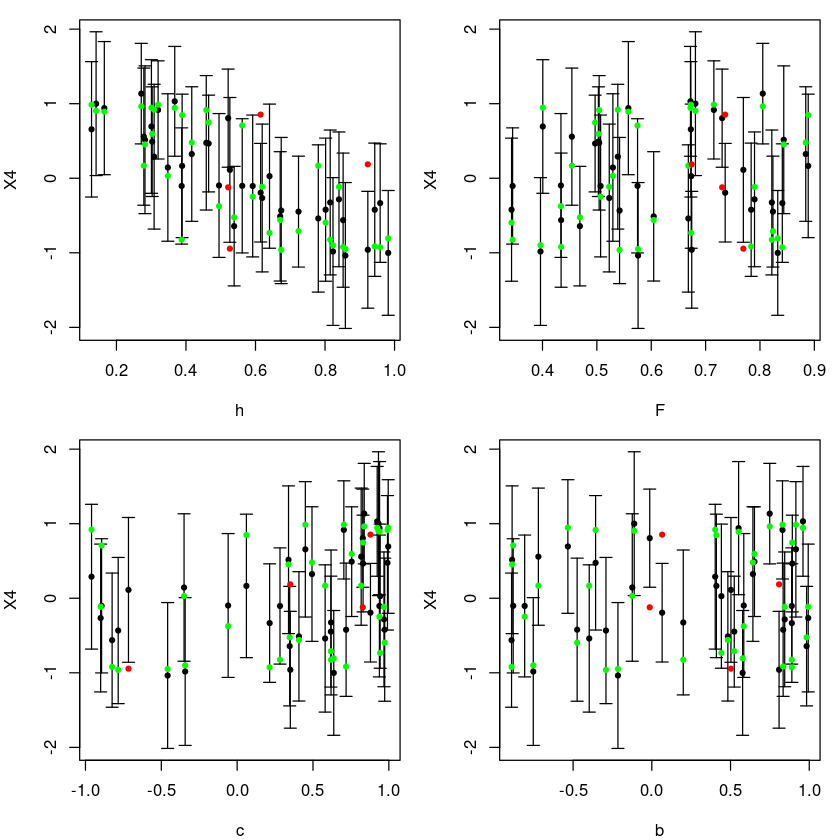

In [48]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [49]:
tDisc_ae_wave2 <- rep(0, ncol(X_ae)) # model discrepancy variance Var[g] 
tObsErr_ae_wave2 <- rep(0, ncol(X_ae)) # observational error variance Var[e]
obs_scaled_wave2 <- my.scaler_wave2$transform(t(observations))
tObs_ae_wave2 <-  encoder %>% predict(obs_scaled_wave2)

In [50]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc_ae_wave2, Obs=tObs_ae_wave2, ObsErr=tObsErr_ae_wave2))

   user  system elapsed 
 28.200   8.115   8.003 

In [51]:
valmax = 0 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [52]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

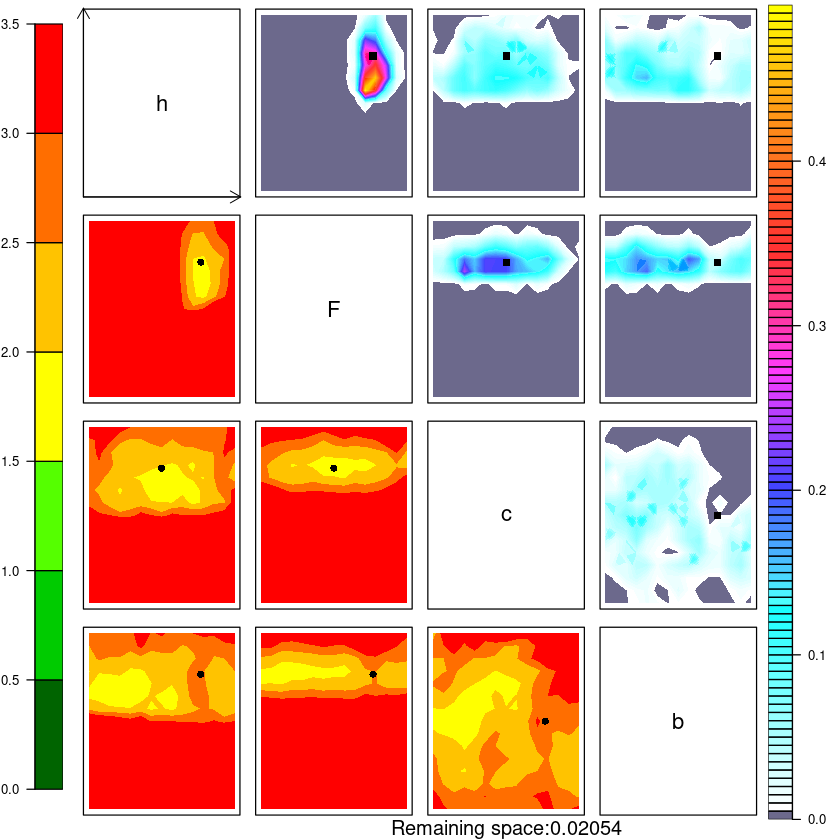

In [53]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [54]:
n <- ceiling(n_samples*20/scoreNROY2)

In [ ]:
space <- skSpace$Space(list(c(-1, 1), c(-1,1), c(-1, 1), c(-1, 1))) ## we use a scaled space
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [ ]:
parameters_space <- function(emulators, NewData, n_samples=n_samples, Discrepancy, Obs, ObsErr){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc_ae, Obs=tObs_ae, ObsErr=tObsErr_ae)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [ ]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 40, tDisc_ae, tObs_ae, tObserr_ae)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [ ]:
inputs_wave2_scaled <- inputs_wave2_scaled_temp[NROY_temp_wave2,]
inputs_wave2 <- rangeUnscale(inputs_wave2_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,3))
plot(inputs_wave2[,1], inputs_wave2[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,1], inputs_wave2[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,2], inputs_wave2[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave2[,3], inputs_wave2[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave2 = future_sapply(1:nrow(inputs_wave2), function(r) extract_metrics_AMIP(inputs_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave2 <- t(metrics_wave2)

## Autoencoder for dimensionality reduction

In [ ]:
inputs_test_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(21)))

In [ ]:
NROY_temp_test_wave2 <- parameters_space(emulators, inputs_test_wave2_scaled_temp, 40, tDisc_ae, tObs_ae, tObserr_ae)

In [ ]:
inputs_test_wave2_scaled <- inputs_test_wave2_scaled_temp[NROY_temp_test_wave2,]
inputs_test_wave2 <- rangeUnscale(inputs_test_wave2_scaled, my_bounds, range = c(-1, 1))

In [ ]:
metrics_test_wave2 = future_sapply(1:nrow(inputs_test_wave2), function(r) extract_metrics_AMIP(inputs_test_wave2[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave2 <- t(metrics_test_wave2)

In [ ]:
sobol <- sampler$Sobol()
inputs_wave3_scaled_temp <- np$array(sobol$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, n_samples=40)

In [ ]:
length(NROY_temp_wave3)

In [ ]:
inputs_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
inputs_wave3 <- rangeUnscale(inputs_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,3))
plot(inputs_wave3[,1], inputs_wave3[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave3[,1], inputs_wave3[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave3[,1], inputs_wave3[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave3[,2], inputs_wave3[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave3[,2], inputs_wave3[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave3[,3], inputs_wave3[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave3 = future_sapply(1:nrow(inputs_wave3), function(r) extract_metrics_AMIP(inputs_wave3[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_wave3 <- t(metrics_wave3)

### Dimensionality reduction

In [ ]:
# Generate data for testing PCA
n_samples_test <- 40
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))
metrics_test_wave3 = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave3 <- t(metrics_test_wave3)

In [ ]:
# Generate data for testing PCA
n_samples_test <- 40
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))
metrics_test_wave3 = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave3 <- t(metrics_test_wave3)

In [ ]:
space <- skSpace$Space(list(c(-1, 1), c(-1,1), c(-1, 1), c(-1, 1))) ## we use a scaled space
inputs_wave3_scaled_temp_test <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(21)))

In [ ]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_test_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp_test, 40, tDisc_ae, tObs_ae, tObserr_ae)

In [ ]:
inputs_test_wave3_scaled <- inputs_wave3_scaled_temp_test[NROY_temp_test_wave3,]
inputs_test_wave3 <- rangeUnscale(inputs_test_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
# Generate data for testing PCA
metrics_test_wave3 = future_sapply(1:nrow(inputs_test_wave3), function(r) extract_metrics_AMIP(inputs_test_wave3[r,], n_iter, 0.001, X_init), future.seed=NULL)
metrics_test_wave3 <- t(metrics_test_wave3)

In [ ]:
# Scale metrics
my.scaler_wave3 <- sklearn$preprocessing$StandardScaler()
X_wave3 <- my.scaler_wave3$fit_transform(metrics_wave3)
X_test_wave3 <- my.scaler$transform(metrics_test_wave3)

In [ ]:
latent_size <- 32

#Create encoder
enc_input = layer_input(shape = input_size)
enc_output = enc_input %>% 
  layer_dense(units=latent_size, activation = "tanh") 
encoder = keras_model(enc_input, enc_output)

#Create decoder
dec_input = layer_input(shape = latent_size)
dec_output = dec_input %>% 
  layer_dense(units = input_size, activation = "linear") #%>%
  #layer_dropout(rate=0.05)
decoder = keras_model(dec_input, dec_output)

#Create autoencoder
aen_input = layer_input(shape = input_size)
aen_output = aen_input %>% 
  encoder() %>% 
  decoder()
   
ae = keras_model(aen_input, aen_output)
summary(ae)

In [ ]:
ae %>% compile(optimizer="Adam", loss="mean_squared_error")
ae %>% fit(X_wave3, X_wave3, epochs=400, batch_size=8, validation_data =list(X_test_wave3, X_test_wave3), workers=8, use_multiprocessing=TRUE)

In [ ]:
loss <- ae$history$history$loss
val.loss <- ae$history$history$val_loss
max.loss <- max(c(loss, val.loss))
plot(loss, type='b', ylim=c(0, max.loss))
lines(val.loss, col='red', type='b')
legend(600, 1, legend=c("AE mse", "AE val mse"), 
       col=c('black', 'red'),
       lty=1:4,
       title="Losses")


### Create the data matrix

In [ ]:
# Arrange inputs (parameters) 
inputs_wave3 <- data.frame(inputs_wave3)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave3_scaled <- rangeScale(inputs_wave3, my_bounds, range = c(-1, 1))
names(inputs_wave3_scaled) <- c('h', 'F', 'c', 'b')


X_ae_wave3 <- encoder %>% predict(X_wave3)
N = nrow(X_ae_wave3) 
noise <- rnorm(N, 0.5, 0)
tData_ae_wave3 <- data.frame(cbind(inputs_wave3_scaled, noise, X_ae_wave3))
names(tData_ae_wave3)[names(tData_ae_wave3) == "noise"] <- "Noise"
         
head(tData_ae_wave3)

### Training emulator

In [ ]:
em_wave3 <- BuildNewEmulators(tData_ae_wave3, HowManyEmulators = ncol(X_ae_wave3), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
tDisc_ae_wave3 <- rep(0, ncol(X_ae_wave3)) # model discrepancy variance Var[g] 
tObsErr_ae_wave3 <- rep(0, ncol(X_ae_wave3)) # observational error variance Var[e]
obs_scaled_wave3 <- my.scaler_wave2$transform(t(observations))
tObs_ae_wave3 <-  encoder %>% predict(obs_scaled_wave3)

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc_ae_wave3, Obs=tObs_ae_wave3, ObsErr=tObsErr_ae_wave3))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

In [ ]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [ ]:
n <- ceiling(n_samples*/scoreNROY3)

In [ ]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
emulators <- list(em_wave1, em_wave2, em_wave3)
NROY_temp_wave4 <- parameters_space(emulators, inputs_wave4_scaled_temp, 30)

In [ ]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

### Training emulator

In [ ]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

In [ ]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)